In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [37]:
data = pd.read_csv('VIX_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data_clean = data
data_clean.fillna(data_clean.mean(), inplace=True)

In [38]:
explanatory_vars = data_clean.drop(columns=['Date','VIX'])

# Unlagged

In [39]:
all_feature_names = list(explanatory_vars.columns)
best_features = []
best_rmse = float('inf')
remaining_features = all_feature_names.copy()

In [40]:
y = data_clean['VIX']

In [41]:
for i in range(len(remaining_features)):
    feature_to_add = None
    for feature in remaining_features:
        selected_features = best_features + [feature]
        X_subset = data_clean[selected_features]
        # Split Data so that the first 80% of the data is used for training and the next 10% is used for model optimization, then the next 10% is used for testing
        X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y, test_size=0.2, shuffle=False)
        X_opt_subset, X_test_subset, y_opt_subset, y_test_subset = train_test_split(X_test_subset, y_test_subset, test_size=0.5, shuffle=False)
        rf_model_subset = RandomForestRegressor(n_estimators=500, random_state=42)
        rf_model_subset.fit(X_train_subset, y_train_subset)
        y_pred_subset = rf_model_subset.predict(X_opt_subset)
        # Calculate rmse
        rmse_subset = root_mean_squared_error(y_opt_subset, y_pred_subset)
        print(selected_features)
        print(rmse_subset)
        if rmse_subset < best_rmse:
            best_rmse = rmse_subset
            feature_to_add = feature
    if feature_to_add:
        best_features.append(feature_to_add)
        remaining_features.remove(feature_to_add)
    else:
        break

best_features, best_rmse

['Unemployment Rate']
5.376331149213692
['CPI']
7.615843104318713
['Three Month T Bill Rate']
6.282801457302046
['Six Month T Bill Rate']
7.310462286210011
['10-Year Treasury Constant Maturity Rate']
6.9593646813770516
['Fed Rate']
5.246660796960316
['BBB Rate']
8.422602846868784
['SP500 Index']
4.305851233318418
['GDP']
6.805237134448548
['Initial Claims']
6.98626411803171
['JPY/USD Spot Rate']
7.559423796417944
['Total Nonfarm Employees']
7.321323366413939
['Spot Crude Oil Price']
4.719117575238001
['SP500 Volume']
4.203412437234799
['NASDAQ Open']
6.842791089966172
['NASDAQ High']
6.168496799124547
['NASDAQ Low']
4.449207420384018
['NASDAQ Close']
5.074906204638648
['NASDAQ Adj Close']
5.074906204638648
['NASDAQ Volume']
4.82392034299495
['DJI Open']
5.484275415803855
['DJI High']
4.988459570353357
['DJI Low']
5.382936284901616
['DJI Close']
4.7844056438548535
['DJI Adj Close']
4.7844056438548535
['DJI Volume']
5.523473838075994
['RUSSELL2000 Open']
6.783675722930075
['RUSSELL2000 H

(['NIKKEI Low', 'GOLD Volume', 'Spot Crude Oil Price', 'SP500 Index'],
 2.4071291678511977)

In [48]:
X = data_clean[best_features]
y = data_clean['VIX']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_opt, X_test, y_opt, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

In [50]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [51]:
y_pred = rf_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
rmse

2.8192305973520906

In [52]:
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

In [53]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

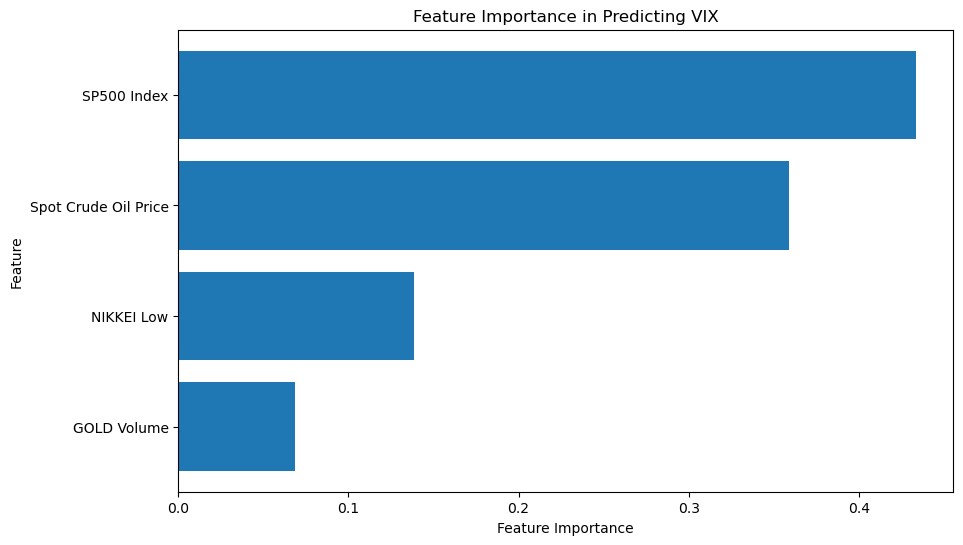

In [54]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting VIX')
plt.gca().invert_yaxis()
plt.show()

In [65]:
# Add dates back to y_test and y_pred and add columns header to predicted values
y_test_df = pd.DataFrame(y_test)
y_test_df['Date'] = data_clean.index[y_test.index]
y_pred_df = pd.DataFrame(y_pred)
y_pred_df['Date'] = data_clean.index[y_test.index]
y_pred_df.columns = ['Predicted VIX', 'Date']

In [66]:
y_pred_df

,Predicted VIX,Date
0,14.58525,2019-10-01
1,13.30438,2019-11-01
2,15.25136,2020-01-01
3,17.81888,2020-02-01
4,33.52779,2020-04-01
5,26.84952,2020-05-01
6,27.45531,2020-06-01
7,24.66140,2020-07-01
8,22.34170,2020-08-01
9,26.17601,2020-09-01


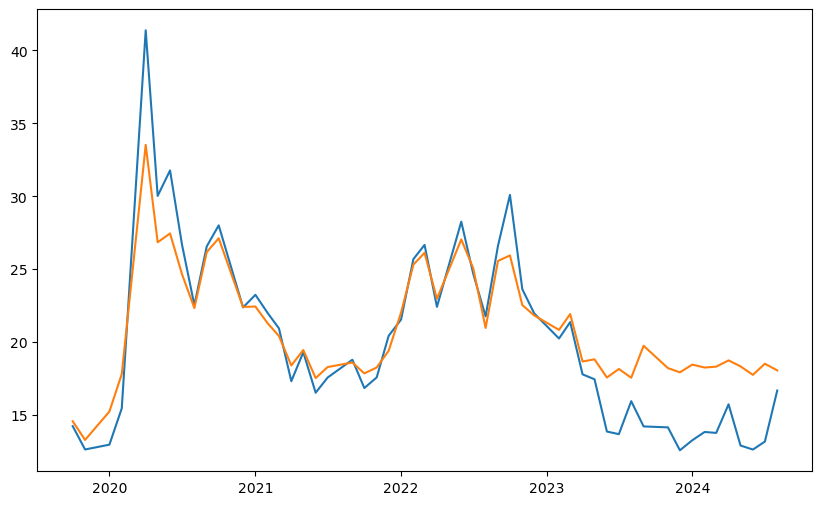

In [67]:
# Plot the actual VIX and the predicted VIX for the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test_df['Date'], y_test_df['VIX'], label='Actual VIX')
plt.plot(y_test_df['Date'], y_pred_df['Predicted VIX'], label='Predicted VIX')
